## Coding for Lecture VI

by *Suwichaya Suwanwimolkul, Ph.D.*

The coding exercies and examples are used as parts of  *Lecture VI: LMSE, Wiener Filtering, Maximum A Posteriori*  in **Estimation Theory EE2102523**. 

The topics covered in this exercise are: 
- [Wiener Filtering](#wiener-filter)  
    - [Initialization](#initial-settings)
    - [Wiener Filter Algorithm](#wiener-filter-algorithm)
    - [Apply Wiener Fitler](#apply-wiener-filter)
- [Maximum A Posteriori Estimation](#maximum-a-posteriori-estimation)
    - [The MAP Algorithm](#map-algorithm)
    - [Extension to estimate parameters in priors](#extend-the-map-estimator-to-update-the-parameters-of-prior-distribution)
    - [Apply to reconstruct compressed data](#apply-map-estimation)


Note: Don't forget to do `pip install -r requirements.txt`

References:

1. How to check https://online.stat.psu.edu/stat510/
2. Coding (in matlab version): https://dspcookbook.github.io/ ...


In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import numpy as np
from scipy.linalg import toeplitz 
import pdb

## Wiener Filtering

Important Assumption: 

- Signal and (additive) noise are stationary

- They have known spectral characteristics or known autocorrelation and cross-correlation.

Therefore, we will perform the following checking on our generated signals to simulate the excericse in the lecture note. 


### Initializatoin  

**Simulating the target signal**

We want to extract $X[n]$ with autocorrelation $R_{xx}[k] = 0.95^{|k|}$ which is wide-sense stationary.  

In [2]:
def Rxx_function(a, var_x, tau):
    rxx     = var_x*(a**abs(tau))
    return rxx

In [3]:
# Generate a time-series signal x and our system will observe y  
N       = 10000
var_x    = 1
var_v    = 2
a       = 0.95
num_filter_coeff  = 3  

# Synthesize x[n] as a time-series data with auto correlation 0.95^{|k|}
u       = np.sqrt(var_x)*np.random.randn(N)   
x       = [0]   

# Generate the noisy time-series data
for n in range(1,N):
    x.append(a*x[n-1] + u[n])  # auto correlation 0.95^{|k|} 

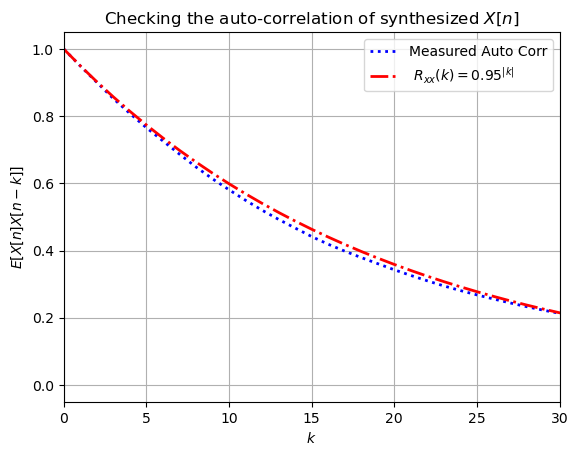

In [4]:
# Check the auto correlation.
import statsmodels.api as sm
x_array = np.array(x)
auto_corr       = sm.tsa.acf(x_array)
k               = np.arange(N)
auto_corr_func  = Rxx_function(a, var_x, k)


plt.plot(auto_corr, ":b", linewidth=2, label="Measured Auto Corr")
plt.plot(auto_corr_func, "-.r", linewidth=2, label=" $R_{xx} (k) = 0.95^{|k|}$ ")
plt.xlim(0,30) 
plt.ylabel("$E[X[n] X[n-k]]$")
plt.xlabel("$k$")
plt.title("Checking the auto-correlation of synthesized $X [n]$")
plt.grid()
plt.legend()

**Simulating the observations**

Nevertheless, we observed its noisy version $Y[n]$ where $Y[n] = X[n] + V[n]$ with variance $\sigma_V^2 = 2$ and $R_{vv}[k] = 2 \delta[k]$. 

$X[n]$ and $V[n]$ are uncorrelated, zero mean, jointly wide-sense stationary random process.    

In [5]:
# v is observation noise
v       = np.sqrt(var_v)*np.random.randn(N) 
# Our filter will observe y = x + n
y       = x + v  

In [6]:
def Ryx_function(var_x, a, k):
    ryx     = var_x*(a**abs(k))
    return ryx

def Ryy_function(var_x, a, var_v, k):
    delta = np.zeros_like(k)
    delta[0] = var_v
    ryy     = var_x*(a**abs(k)) + delta
    return ryy 

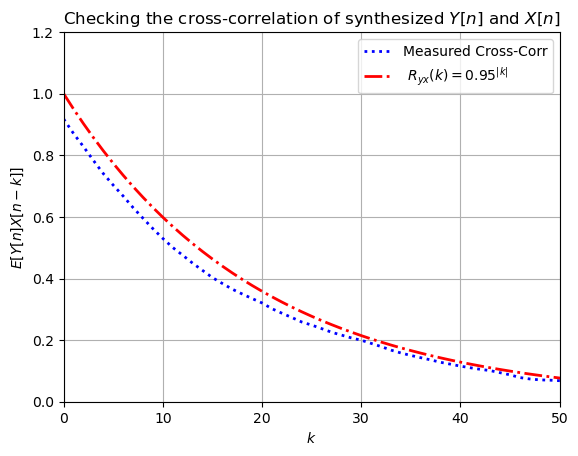

In [7]:
# Check the cross-correlation.
import statsmodels.api as sm

k               = np.arange(N)
auto_corr_func  = Ryx_function(var_x, a, k) 
r_yx_sim        = sm.tsa.stattools.ccf(x,y)

plt.plot(r_yx_sim, ":b", linewidth=2, label="Measured Cross-Corr")
plt.plot(auto_corr_func, "-.r", linewidth=2, label=" $R_{yx} (k) = 0.95^{|k|}$ ")
plt.xlim(0,50) 
plt.ylim(0,1.2) 
plt.ylabel("$E[Y[n] X[n-k]]$")
plt.xlabel("$k$")
plt.title("Checking the cross-correlation of synthesized $Y [n]$ and $X [n]$")
plt.grid()
plt.legend()

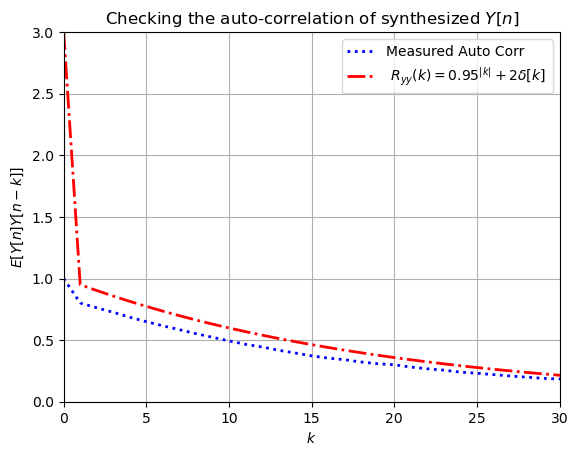

In [8]:
# Check the cross-correlation.
import statsmodels.api as sm

k               = np.arange(N)
auto_corr_func  = Ryy_function(var_x, a, var_v, k) 
r_yx_sim        = sm.tsa.acf(y)

plt.plot(r_yx_sim, ":b", linewidth=2, label="Measured Auto Corr")
plt.plot(auto_corr_func, "-.r", linewidth=2, label=" $R_{yy} (k) = 0.95^{|k|} + 2 \delta [k]$ ")
plt.xlim(0,30) 
plt.ylim(0,3) 
plt.ylabel("$E[Y[n] Y[n-k]]$")
plt.xlabel("$k$")
plt.title("Checking the auto-correlation of synthesized $Y [n]$")
plt.grid()
plt.legend()

### Wiener Filter Algorithm

In [9]:
# Wiener Filter algorithm 

def wiener_filt( y, param_Rxx = [a, var_x],  var_v=var_v, M = num_filter_coeff):
    
    # Step 1: Initialization
    a       = param_Rxx[0]
    var_x   = param_Rxx[1]

    tau     = np.arange(0,M)      
    rnn     = np.zeros_like(tau)
    rnn[0]  = var_v;             # Autocorrelation is a Kronecker Delta function 
    
    # Step 2.
    rxx     = Rxx_function(a, var_x, tau )
    # Step 3
    ryy     = rxx + rnn            # Autocorrelation vector 
    # Step 4
    Ryy     = toeplitz(ryy);       # Autocorrelation matrix  
    # Step 5
    ryx     = rxx  
    # Step 6 
    a_      = np.linalg.inv(Ryy).dot(ryx)  
    # Step 7 
    g = []
    for n_ in range(M-1,N):
        g.append(a_.dot(np.flipud(y[(n_-M+1):n_+1])))

    return np.array(g), a_

### Apply Wiener Filter

In [10]:

g, a_ = wiener_filt( y, param_Rxx = [a, var_x],  var_v=var_v, M = num_filter_coeff)
print("Filter Coefficients:", a_)

Filter Coefficients: [0.22028816 0.19187074 0.17380425]


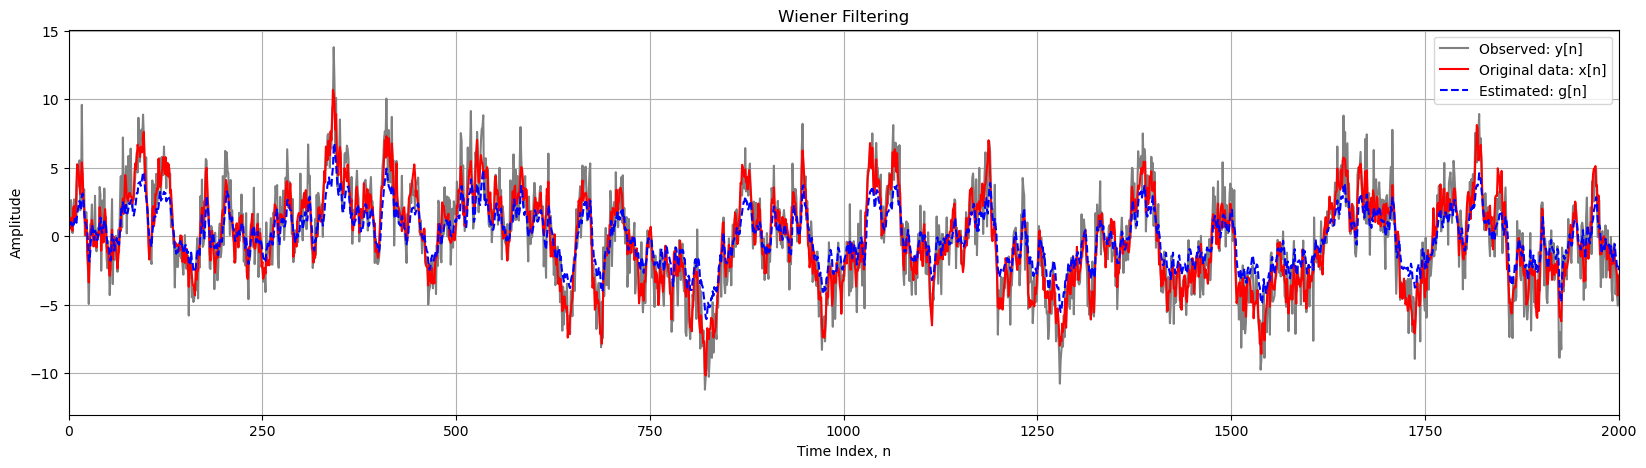

In [11]:
plt.figure(figsize=[20,5])

stime_index = np.arange(0,N)
ytime_index = np.arange(num_filter_coeff-1,N)
# Plot result
plt.plot(stime_index, y, label="Observed: y[n]", color="gray")
plt.plot(stime_index, x, label="Original data: x[n]", color="red") 
plt.plot(ytime_index, g, label="Estimated: g[n]", linestyle= '--', color="blue")
plt.grid()

plt.xlim([0,2000])
plt.legend() #'y(n)','g(n)','x(n)'
plt.xlabel("Time Index, n")
plt.ylabel("Amplitude")
plt.title('Wiener Filtering')
plt.show()

## Maximum A Posteriori Estimation

### MAP Algorithm

The likelihood $f_{Y|X}(y|x)$ is $ f_{Y|X}(y|x) = \mathcal{N}(AX, \sigma_V^2)$, and the prior $f_{X}(x)$  is $ f_{X}(x) = \text{Laplacian}(X; \lambda, \mu)$.  

 
Thus, the MAP can be formulated by  
$$\argmin_{x \in \mathcal{R}^N}  \mathcal{L}(x)  =  \frac{1}{\sigma_V^2} {|| y - Ax ||^2_2} +  \lambda^{-1} || x - \mu||_1  $$  

This steps follow the equations provided in the lecture...

That is, the solutions to this problem are in a soft thresholding form: 

\begin{align}
    x_j^{MAP} = 
    \begin{cases}
        \frac{1}{2} (2 y^T A_j - \lambda^{-1}_j \sigma^2_V), &\text{if}~x_j > \mu_j   \\
        \frac{1}{2} (2 y^T A_j + \lambda^{-1}_j \sigma^2_V), &\text{if}~x_j < \mu_j    \\
        0, &\text{otherwise}.
    \end{cases}
\end{align}

Note that in the code below we add the condition there $x_j > 0$ since they are representing pixel values.

In [12]:
def MAPEstimator(y, A, sigma_v, lambda_gamm, mu_gamma): 

    dff = sigma_v/(2*lambda_gamm  )
 
    X   = (y.transpose().dot(A)).transpose()

    x_return = np.zeros_like(X) 
    value_a = X - dff   

    case_a  = (value_a > mu_gamma) *(value_a > 0 )
    x_return[case_a] = value_a[case_a]
 
    value_b = X + dff  
    case_b  = (value_b < mu_gamma ) *(value_b > 0 )
    x_return[case_b] = value_b[case_b]
     
    return x_return

### Extend the MAP Estimator to update the parameters of prior distribution

We estimate the parameters in prior distribution, namely $\mu$ and $\lambda$ in $\text{Laplacian}(X; \lambda, \mu)$.

We can solve for this via maximum likelihood estimation:

$$ \argmax_{\lambda, \mu} \mathcal{L}_{Lap}(X; \lambda, \mu)  = \sum_{i=1}^N  ( \log{\frac{1}{2b}} - \frac{|x_i - \mu|}{b} ) $$ 

For this, we can estimate these two parameters as follows:
- $\partial_{\mu} \mathcal{L}_{Lap}(X; \lambda, \mu)  \Rightarrow   \mu = \frac{\sum_i x_i}{N}$
- $\partial_{b} \mathcal{L}_{Lap}(X; \lambda, \mu)  \Rightarrow   b    = \frac{\sum_i |x_i - \mu|}{N} $


In [13]:
## These functions are used to update the mu and lambda in Laplacian Distribution

def update_b(data2D):
    mean_2d = np.mean(data2D, axis=2)
    b = np.mean(np.abs(data2D - mean_2d.reshape(28,28,1)), axis=2) 
    return b

def sample_mean(data2D):
    mean_2d = np.mean(data2D, axis=2)    
    return mean_2d

In [14]:
def loopy_Estimation(y, A, sigma_v, lambda_gamm, mu_gamma, num_iteration):
    mu_gamma_updated    = mu_gamma
    lambda_gamm_updated = lambda_gamm
    Num_samples = y.shape[1]
    x_return_list = [] 
    for i in range(num_iteration):
        x_return = MAPEstimator(y, A, sigma_v, lambda_gamm_updated, mu_gamma_updated)  
        data2D_update       = x_return.reshape(28,28, Num_samples) 
        mu_gamma_updated    = sample_mean(data2D_update) 
        mu_gamma_updated    = mu_gamma_updated.reshape(28*28,1)

        lambda_gamm_updated = update_b(data2D_update) 
        lambda_gamm_updated = lambda_gamm_updated.reshape(28*28,1)
        x_return_list.append(x_return)
  
        
    return x_return_list

#### Load Data

In [15]:
import numpy as np 
import matplotlib.pyplot as plt 
import numpy as np 

import torch
import torch.utils.data  
from torchvision import datasets, transforms 


test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True,
                transform=transforms.ToTensor()), batch_size=1, shuffle=False)

data_vect = []
label_vect_ = []
for i, (data, label) in enumerate(test_loader):
    data_vect.append(data.view(28,28).numpy())
    label_vect_.append(label.numpy()[0])

label_vect  = np.array(label_vect_)
data2D      = np.stack(data_vect, axis=-1)
Num_samples = data2D.shape[2]

#### Simulation Settings

In [16]:
sigma_v           = 1e-10
num_iteration     = 5
compression_ratio = 0.5 

n_compressed_data = int(compression_ratio*28*28) 
A                 = np.random.randn(n_compressed_data, 28*28)/np.sqrt(n_compressed_data)  
v                 = sigma_v*np.random.randn(1, 1)  
yA                = A.dot(data2D.reshape(28*28,-1)).reshape(n_compressed_data,-1)  

y                 = yA  + v  

### Apply MAP Estimation

In [21]:
mu_gamma_    = sample_mean(data2D)
mu_gamma    =  mu_gamma_.reshape(28*28,1)

lambda_gamm_ = update_b(data2D)  
lambda_gamm  = lambda_gamm_.reshape(28*28,1)

x_hat_list   = loopy_Estimation(y, A,  0.01, lambda_gamm, mu_gamma, num_iteration)

/tmp/ipykernel_56390/3819130981.py:3: RuntimeWarning: divide by zero encountered in divide
  dff = sigma_v/(2*lambda_gamm  )


### Plot outputs

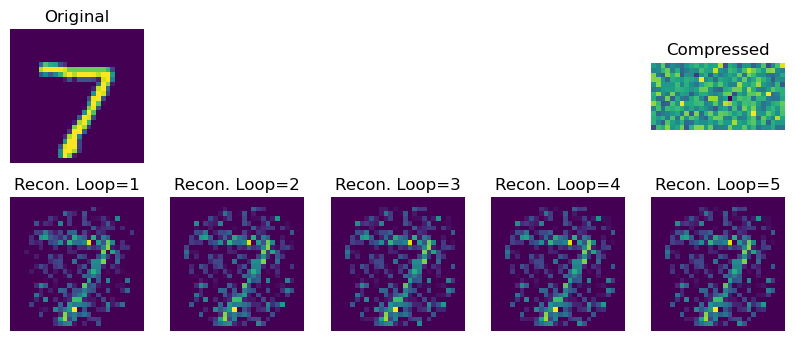

In [22]:
Num_samples       = y.shape[1]

x_hat_2D_6    = x_hat_list[-5].reshape(28,28, Num_samples)[:,:,0]    
x_hat_2D_7    = x_hat_list[-4].reshape(28,28, Num_samples)[:,:,0]    
x_hat_2D_8    = x_hat_list[-3].reshape(28,28, Num_samples)[:,:,0]    
x_hat_2D_9    = x_hat_list[-2].reshape(28,28, Num_samples)[:,:,0]  
x_hat_2D_10   = x_hat_list[-1].reshape(28,28, Num_samples)[:,:,0] 

fig, ax = plt.subplots(nrows=2,ncols=5, figsize=(10,4) )

ax[0,0].imshow(data2D[:,:,0] ) 
ax[0,0].set_title("Original")
ax[0,4].imshow(y[:,0].reshape(-1,28)) 
ax[0,4].set_title("Compressed")

ax[0,0].set_axis_off()
ax[0,1].set_axis_off()
ax[0,2].set_axis_off()
ax[0,3].set_axis_off()
ax[0,4].set_axis_off()


ax[1,0].imshow(x_hat_2D_6)
ax[1,1].imshow(x_hat_2D_7)
ax[1,2].imshow(x_hat_2D_8)
ax[1,3].imshow(x_hat_2D_9)
ax[1,4].imshow(x_hat_2D_10)

ax[1,0].set_axis_off()
ax[1,1].set_axis_off()
ax[1,2].set_axis_off() 
ax[1,3].set_axis_off()
ax[1,4].set_axis_off()

ax[1,0].set_title("Recon. Loop=1")
ax[1,1].set_title("Recon. Loop=2")
ax[1,2].set_title("Recon. Loop=3")
ax[1,3].set_title("Recon. Loop=4")
ax[1,4].set_title("Recon. Loop=5")

plt.show()